# 1. Imports & Global Config

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import torch
import random
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
from safetensors.torch import load_file as load_safetensors
from tqdm.auto import tqdm
try:
    from torchmetrics.image import StructuralSimilarityIndexMeasure
except ImportError:
    !pip install torchmetrics
    from torchmetrics.image import StructuralSimilarityIndexMeasure

from diffusers import DiffusionPipeline, UNet2DModel, DDPMScheduler, DDIMScheduler
from PIL import Image

from scipy import linalg
from sklearn.metrics.pairwise import polynomial_kernel
from skimage.exposure import match_histograms

# --------------------------------------------
# Paths — EDIT THESE FOR YOUR ENVIRONMENT
# --------------------------------------------
BASE = Path("/content/drive/MyDrive/Dataset")  # project root
print("BASE:", BASE)

ENTITY  = "challenger"
PROJECT = "brats-counterfactual-diffusion"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# W&B artifact identifiers
M1_ARTIFACT = f"{ENTITY}/{PROJECT}/model1_uncond_ddim:v0"
M2_ARTIFACT = f"{ENTITY}/{PROJECT}/checkpoint-epoch-60:v2"
M3_ARTIFACT = f"{ENTITY}/{PROJECT}/checkpoint-epoch-60:v0"

# Local extraction dirs inside the Colab runtime
M1_DIR = Path("/content/model_checkpoint/m1_checkpoint")
M2_DIR = Path("/content/model_checkpoint/m2_checkpoint")
M3_DIR = Path("/content/model_checkpoint/m3_checkpoint")

# Segmentation U-Net (Model 4) checkpoint
SEG_UNET_CKPT = BASE / "checkpoints" / "unet_best_5class.pth"

# Dataset layout: train/val/test each with flair/ and mask/ folders
DATA_ROOT   = BASE / "brats_final_split"
VAL_IMG_DIR = DATA_ROOT / "val"  / "flair"
VAL_MASK_DIR= DATA_ROOT / "val"  / "mask"
TEST_IMG_DIR= DATA_ROOT / "test" / "flair"
TEST_MASK_DIR=DATA_ROOT / "test" / "mask"

IMG_SIZE = 256
NUM_CLASSES = 5
# Global evaluation configuration (centralized knobs)
EVAL_CFG = {
    "fid_kid": {   # FID/KID in seg-UNet feature space
        "N_GEN": 1024,
        "BATCH": 16,
        "STEPS": 20,
    },
    "ssim": {      # SSIM between real vs generated pairs
        "N_PAIRS": 256,
        "STEPS": 50,
    },
    "gen_seg": {   # Dice/IoU on generated images vs GT via M4
        "N_PAIRS": 256,
        "BATCH": 8,
        "STEPS": 50,
    },
}

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


BASE: /content/drive/MyDrive/Dataset
Mounted at /content/drive
Using device: cuda


In [2]:
!pip install -q wandb diffusers safetensors
#wandb API Key : YOUR_WANDB_API_KEY_HERE
!wandb login

!mkdir -p /content/model_checkpoint/m1_checkpoint
!wandb artifact get $M1_ARTIFACT --root /content/model_checkpoint/m1_checkpoint

!mkdir -p /content/model_checkpoint/m2_checkpoint
!wandb artifact get $M2_ARTIFACT --root /content/model_checkpoint/m2_checkpoint

!mkdir -p /content/model_checkpoint/m3_checkpoint
!wandb artifact get $M3_ARTIFACT --root /content/model_checkpoint/m3_checkpoint

print("M1, M2, M3 checkpoint are ready at /content/model_checkpoint")

# 2. Data Utilities (Shared by All Metrics)

In [3]:
# Basic image transforms
img_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
])


def load_image(path: Path) -> torch.Tensor:
    """Load a FLAIR slice as tensor (1,H,W), normalized to [0,1]."""
    img = Image.open(path).convert("L")
    t = img_transform(img)
    return t


def load_mask_raw(path: Path) -> np.ndarray:
    """
    Load a mask PNG as raw numpy array (H,W) or (H,W,3) depending on how it was saved.
    We keep this low-level; conversion to labels happens in dataset.
    """
    m = Image.open(path)
    m = m.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
    return np.array(m)


def load_diffusion_mask(mask_path: Path) -> torch.Tensor:
    """
    Load diffusion mask and map BraTS grayscale values to class indices,
    then encode as cls / 255.0 (0..4 -> 0..4/255)
    """
    mask_img = Image.open(mask_path).convert("L")
    mask_img = mask_img.resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
    mask_arr = np.array(mask_img, dtype=np.int64)


    cls_arr = np.zeros_like(mask_arr, dtype=np.float32)
    for src_val, target_cls in DIFF_MASK_VALUE_TO_CLASS.items():
        cls_arr[mask_arr == src_val] = float(target_cls)


    norm = cls_arr / 255.0
    return torch.from_numpy(norm).unsqueeze(0).unsqueeze(0).to(device)


def collect_paired_paths(img_dir: Path, mask_dir: Path, limit: int = None):
    """
    Return filename-matched pairs of (flair, mask) as lists of Paths.
    Only keep files where both flair and mask exist.
    """
    all_imgs  = sorted(img_dir.glob("*.png"))
    all_masks = sorted(mask_dir.glob("*.png"))

    mask_lookup = {m.name: m for m in all_masks}

    paired_imgs  = []
    paired_masks = []

    for img_path in all_imgs:
        fname = img_path.name
        if fname in mask_lookup:
            paired_imgs.append(img_path)
            paired_masks.append(mask_lookup[fname])

    if limit is not None:
        paired_imgs  = paired_imgs[:limit]
        paired_masks = paired_masks[:limit]

    print(f"[collect_paired_paths] dir={img_dir.name}")
    print("  flair:", len(all_imgs))
    print("  mask :", len(all_masks))
    print("  paired:", len(paired_imgs))
    return paired_imgs, paired_masks

def tensor_to_pil(t: torch.Tensor) -> Image.Image:
    """
    Convert a tensor (1,1,H,W) or (1,H,W) in [0,1] to a grayscale PIL image.
    """
    if t.dim() == 4:
        t = t[0, 0]
    elif t.dim() == 3:
        t = t[0]

    arr = t.detach().cpu().numpy()


    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)

    return Image.fromarray(arr, mode="L")

# 3. Segmentation U-Net (Model 4) + Dice Utilities

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        return self.conv(self.pool(x))


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Pad to match shape
        diff_y = x2.size(2) - x1.size(2)
        diff_x = x2.size(3) - x1.size(3)

        x1 = F.pad(
            x1,
            [
                diff_x // 2,
                diff_x - diff_x // 2,
                diff_y // 2,
                diff_y - diff_y // 2,
            ],
        )

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNetSeg(nn.Module):
    def __init__(self, in_channels=1, num_classes=NUM_CLASSES, base_ch=64):
        super().__init__()

        self.inc = DoubleConv(in_channels, base_ch)
        self.down1 = Down(base_ch, base_ch * 2)
        self.down2 = Down(base_ch * 2, base_ch * 4)
        self.down3 = Down(base_ch * 4, base_ch * 8)
        self.down4 = Down(base_ch * 8, base_ch * 16)

        self.up1 = Up(base_ch * 16, base_ch * 8)
        self.up2 = Up(base_ch * 8, base_ch * 4)
        self.up3 = Up(base_ch * 4, base_ch * 2)
        self.up4 = Up(base_ch * 2, base_ch)

        self.outc = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        return self.outc(x)

COLOR_TO_LABEL = {
    (0,   0,   0): 0,  # Background
    (0,   0, 255): 1,  # CSF
    (0, 255,   0): 2,  # Gray Matter
    (255, 255, 0): 3,  # White Matter
    (255,   0,   0): 4,  # Tumor
}

def rgb_to_label(mask_rgb: np.ndarray) -> np.ndarray:
    """
    mask_rgb: (H,W,3) color mask
    returns: (H,W) integer labels in [0..NUM_CLASSES-1]
    """
    h, w, _ = mask_rgb.shape
    label = np.zeros((h, w), dtype=np.int64)
    for rgb, cls in COLOR_TO_LABEL.items():
        label[(mask_rgb == rgb).all(axis=-1)] = cls
    return label


class BratsFlairSliceDataset(Dataset):
    """
    Paired FLAIR PNG + color-coded mask PNG.
    Root: DATA_ROOT, expects root/split/flair and root/split/mask.
    """

    def __init__(self, root: Path, split: str = "train"):
        self.items = []
        flair_dir = root / split / "flair"
        mask_dir  = root / split / "mask"

        flair_files = sorted(f for f in os.listdir(flair_dir) if f.endswith(".png"))
        for fname in flair_files:
            img_path  = flair_dir / fname
            mask_path = mask_dir  / fname
            if mask_path.exists():
                self.items.append((img_path, mask_path))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, mask_path = self.items[idx]

        # FLAIR grayscale in [0,1]
        img = Image.open(img_path).convert("L")
        img = np.array(img, dtype=np.float32) / 255.0
        img = torch.from_numpy(img).unsqueeze(0)  # (1,H,W)

        # Tissue mask (RGB → class indices 0..4)
        mask_rgb = np.array(Image.open(mask_path))
        mask = rgb_to_label(mask_rgb)            # (H,W)
        mask = torch.from_numpy(mask).long()

        return img, mask

DIFF_MASK_VALUE_TO_CLASS = {
    0:   0,  # Background
    76:  4,  # Tumor
    29:  1,  # CSF
    150: 2,  # Gray Matter
    226: 3,  # White Matter
}

In [5]:
def multiclass_dice(pred_logits: torch.Tensor,
                    target: torch.Tensor,
                    num_classes: int = NUM_CLASSES,
                    eps: float = 1e-6) -> float:
    """
    Hard macro Dice.

    pred_logits: (B, C, H, W)
    target     : (B, H, W) with class indices in [0..C-1]

    Returns mean Dice over all classes.
    """
    # (B, H, W)
    pred_labels = pred_logits.argmax(dim=1)  # (B,H,W)

    per_class_scores = []
    for cls in range(num_classes):
        pred_c = (pred_labels == cls).float()
        tgt_c  = (target == cls).float()

        inter = (pred_c * tgt_c).sum()
        union = pred_c.sum() + tgt_c.sum()

        if union <= 0:
            continue

        dice = (2 * inter + eps) / (union + eps)
        per_class_scores.append(dice)

    if not per_class_scores:
        return 0.0

    return torch.stack(per_class_scores).mean().item()


def multiclass_iou(pred_logits: torch.Tensor,
                   target: torch.Tensor,
                   num_classes: int = NUM_CLASSES,
                   eps: float = 1e-6) -> float:
    """
    Hard macro IoU (a.k.a. Jaccard).

    pred_logits: (B, C, H, W)
    target     : (B, H, W) with class indices in [0..C-1]

    Returns mean IoU over all classes.
    """
    pred_labels = pred_logits.argmax(dim=1)  # (B,H,W)

    per_class_scores = []
    for cls in range(num_classes):
        pred_c = (pred_labels == cls).float()
        tgt_c  = (target == cls).float()

        inter = (pred_c * tgt_c).sum()
        union = pred_c.sum() + tgt_c.sum() - inter

        if union <= 0:
            continue

        iou = (inter + eps) / (union + eps)
        per_class_scores.append(iou)

    if not per_class_scores:
        return 0.0

    return torch.stack(per_class_scores).mean().item()

In [11]:
seg_model = UNetSeg(in_channels=1, num_classes=NUM_CLASSES).to(device)
print("Loading segmentation U-Net from:", SEG_UNET_CKPT)
state = torch.load(SEG_UNET_CKPT, map_location=device)
seg_model.load_state_dict(state)
seg_model.eval()
for p in seg_model.parameters():
    p.requires_grad = False

Loading segmentation U-Net from: /content/drive/MyDrive/Dataset/checkpoints/unet_best_5class.pth


In [ ]:
def evaluate_unet_on_split(split: str = "val", batch_size: int = 8, eps: float = 1e-6):
    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0)

    seg_model.eval()

    inter      = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float64)
    union_dice = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float64)
    union_iou  = torch.zeros(NUM_CLASSES, device=device, dtype=torch.float64)

    with torch.no_grad():
        for imgs, masks in loader:
            imgs  = imgs.to(device)
            masks = masks.to(device)

            logits = seg_model(imgs)
            preds  = logits.argmax(dim=1)

            for cls in range(NUM_CLASSES):
                pred_c = (preds == cls)
                tgt_c  = (masks == cls)

                inter_cls = (pred_c & tgt_c).sum()
                union_cls_dice = pred_c.sum() + tgt_c.sum()
                union_cls_iou  = (pred_c | tgt_c).sum()

                inter[cls]      += inter_cls
                union_dice[cls] += union_cls_dice
                union_iou[cls]  += union_cls_iou

    # Only average over classes that actually appear
    valid = union_dice > 0
    dice_per_class = (2 * inter[valid] + eps) / (union_dice[valid] + eps)
    iou_per_class  = (inter[valid] + eps) / (union_iou[valid] + eps)

    macro_dice = dice_per_class.mean().item()
    macro_iou  = iou_per_class.mean().item()

    print(f"{split} mean Tissue Dice (0–{NUM_CLASSES-1}): {macro_dice:.4f}")
    print(f"{split} mean Tissue IoU  (0–{NUM_CLASSES-1}): {macro_iou:.4f}")
    return macro_dice, macro_iou


print("=== Seg U-Net sanity metrics on real images ===")
val_dice,  val_iou  = evaluate_unet_on_split("val",  batch_size=48)
test_dice, test_iou = evaluate_unet_on_split("test", batch_size=48)
print(f"Val  Dice/IoU:  {val_dice:.4f} / {val_iou:.4f}")
print(f"Test Dice/IoU: {test_dice:.4f} / {test_iou:.4f}")

=== Seg U-Net sanity metrics on real images ===


KeyboardInterrupt: 

# 4. Seg-U-Net Encoder Features for FID/KID



In [ ]:
def extract_seg_encoder_features(seg_model: UNetSeg, x: torch.Tensor) -> torch.Tensor:
    """
    x: (N,1,H,W) tensor in [0,1]
    Returns: (N,C) feature vectors from deepest encoder level.
    """
    with torch.no_grad():
        x1 = seg_model.inc(x)
        x2 = seg_model.down1(x1)
        x3 = seg_model.down2(x2)
        x4 = seg_model.down3(x3)
        x5 = seg_model.down4(x4)

        feats = F.adaptive_avg_pool2d(x5, (1, 1))
        feats = feats.view(feats.size(0), -1)
        return feats


def compute_mean_cov(feats: np.ndarray):
    mu    = np.mean(feats, axis=0)
    sigma = np.cov(feats, rowvar=False)
    return mu, sigma


def compute_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2

    # Always regularize the covariances
    offset = np.eye(sigma1.shape[0]) * eps
    sigma1 = sigma1 + offset
    sigma2 = sigma2 + offset

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if not np.isfinite(covmean).all():
        print("Increasing eps for FID stability.")
        offset = np.eye(sigma1.shape[0]) * (10 * eps)
        covmean, _ = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return float(fid)



def compute_kid(feats_real: np.ndarray,
                feats_gen: np.ndarray,
                degree=3, gamma=None, coef0=1.0):
    """
    KID via polynomial kernel MMD^2 (unbiased).
    """
    k_rr = polynomial_kernel(feats_real, feats_real, degree=degree,
                             gamma=gamma, coef0=coef0)
    k_gg = polynomial_kernel(feats_gen,  feats_gen,  degree=degree,
                             gamma=gamma, coef0=coef0)
    k_rg = polynomial_kernel(feats_real, feats_gen,  degree=degree,
                             gamma=gamma, coef0=coef0)

    n_r = feats_real.shape[0]
    n_g = feats_gen.shape[0]

    np.fill_diagonal(k_rr, 0.0)
    np.fill_diagonal(k_gg, 0.0)

    mmd_rr = k_rr.sum() / (n_r * (n_r - 1))
    mmd_gg = k_gg.sum() / (n_g * (n_g - 1))
    mmd_rg = k_rg.mean()

    kid = mmd_rr + mmd_gg - 2 * mmd_rg
    return float(kid)

In [ ]:
paired_val_imgs, _ = collect_paired_paths(VAL_IMG_DIR, VAL_MASK_DIR, limit=None)

real_feats = []
with torch.no_grad():
    for img_path in paired_val_imgs:
        img = load_image(img_path).unsqueeze(0).to(device)
        feats = extract_seg_encoder_features(seg_model, img)
        real_feats.append(feats.cpu().numpy())

real_feats = np.concatenate(real_feats, axis=0)
mu_real, sigma_real = compute_mean_cov(real_feats)
print("Real feature set shape:", real_feats.shape)

[collect_paired_paths] dir=flair
  flair: 2072
  mask : 2072
  paired: 2072


KeyboardInterrupt: 

# 5. Diffusion Models (M1/M2/M3) + Generation Helpers

In [5]:
def load_uncond_from_dir(checkpoint_dir: Path):
    pipe = DiffusionPipeline.from_pretrained(str(checkpoint_dir))
    pipe.to(device)
    pipe.set_progress_bar_config(disable=True)
    return pipe


def generate_aligned_samples_from_split(
    pipe,
    out_dir: Path,
    split: str = "test",
    limit: int = None,
    steps: int = 50,
):
    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)
    out_dir.mkdir(parents=True, exist_ok=True)

    pipe.to(device)
    pipe.set_progress_bar_config(disable=True)

    n = len(ds) if limit is None else min(limit, len(ds))
    print(f"[{out_dir.name}] Generating {n} aligned samples for split='{split}'")

    with torch.no_grad():
        for i in range(n):
            img_path, _ = ds.items[i]
            fname = img_path.name

            out = pipe(batch_size=1, num_inference_steps=steps)
            pil = out.images[0].convert("L")
            pil = pil.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            pil.save(out_dir / fname)


# -----------------------------
# SEG-GUIDED COMPONENTS
# -----------------------------
def load_seg_guided_components(ckpt_dir: Path):
    unet = UNet2DModel.from_pretrained(str(ckpt_dir / "unet"))
    scheduler = DDPMScheduler.from_pretrained(str(ckpt_dir / "scheduler"))
    unet.to(device)
    unet.eval()
    return unet, scheduler


def sample_seg_guided(
    unet,
    train_scheduler,
    real_mask: torch.Tensor,
    init_image: torch.Tensor,
    num_steps: int = 50,
    seed: int = 42,
    mode: str = "healthy",
    strength: float = 0.35,
):
    """
    Seg-guided sampling (M2 / M3):

      - mode="reconstruct":
          * full mask, no edits to image_0
      - mode="healthy":
          * ablate tumor class in the mask (class 4 -> background)
          * DO NOT manually erase tumor intensities in image_0
            (let the diffusion model rewrite that region).

      This sampler is the same for M2 and M3; differences are due to training
      (noMAT vs fullMAT), which is what we want to evaluate.
    """
    # 1) basic setup
    strength  = float(max(0.0, min(1.0, strength)))
    real_mask = real_mask.to(device)
    cond_mask = real_mask.clone()

    # real image in [-1, 1]
    image_0 = init_image.to(device) * 2.0 - 1.0

    tumor_thresh = (4.0 / 255.0) - 1e-4
    tumor_pixels = (real_mask > tumor_thresh)

    if mode == "healthy":
        # mask ablation: tumor class -> background in mask
        cond_mask[tumor_pixels] = 0.0

    elif mode == "reconstruct":
        # full mask, original image_0
        pass
    else:
        raise ValueError(f"Unknown mode={mode}, expected 'healthy' or 'reconstruct'")

    # unwrap DDP / torch.compile
    unet_to_use = unet.module if hasattr(unet, "module") else unet
    if hasattr(unet_to_use, "_orig_mod"):
        unet_to_use = unet_to_use._orig_mod

    # fresh scheduler for inference
    scheduler = DDPMScheduler.from_config(train_scheduler.config)
    scheduler.set_timesteps(num_steps)
    timesteps = scheduler.timesteps

    # image-to-image strength logic
    if strength <= 0.0:
        image = image_0
        t_iter = timesteps
    else:
        # follow HF "strength" convention: start later in the schedule
        start_idx = int((1.0 - strength) * (len(timesteps) - 1))
        t_start   = timesteps[start_idx]

        torch.manual_seed(seed)
        noise = torch.randn_like(image_0)
        image = scheduler.add_noise(image_0, noise, t_start)
        t_iter = timesteps[start_idx:]

    # denoising loop
    for t in t_iter:
        model_input = torch.cat([image, cond_mask], dim=1)
        with torch.no_grad():
            noise_pred = unet_to_use(model_input, t).sample
        image = scheduler.step(noise_pred, t, image).prev_sample

    # back to [0,1]
    image = (image / 2.0 + 0.5).clamp(0.0, 1.0)
    return image


def generate_aligned_seg_guided(
    unet,
    train_scheduler,
    out_dir: Path,
    split: str = "test",
    limit: int | None = None,
    steps: int = 50,
    mode: str = "healthy",
    strength: float = 0.35,
):
    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)
    out_dir.mkdir(parents=True, exist_ok=True)

    n = len(ds) if limit is None else min(limit, len(ds))
    print(
        f"[{out_dir.name}] Generating {n} seg-guided samples for split='{split}', "
        f"mode='{mode}', strength={strength}, steps={steps}"
    )

    with torch.no_grad():
        for i in range(n):
            img_path, mask_path = ds.items[i]
            fname = img_path.name

            real_img  = load_image(img_path).unsqueeze(0).to(device)
            real_mask = load_diffusion_mask(mask_path)

            gen = sample_seg_guided(
                unet=unet,
                train_scheduler=train_scheduler,
                real_mask=real_mask,
                init_image=real_img,
                num_steps=steps,
                seed=42 + i,
                mode=mode,
                strength=strength,
            )

            pil = tensor_to_pil(gen)
            pil.save(out_dir / fname)


def sample_seg_guided_from_noise(
    unet,
    train_scheduler,
    real_mask: torch.Tensor,
    num_steps: int = 50,
    seed: int = 42,
):
    """
    Pure seg-guided generation from noise, conditioned on real_mask.
    """
    real_mask = real_mask.to(device)
    cond_mask = real_mask.clone()

    unet_to_use = unet.module if hasattr(unet, "module") else unet
    if hasattr(unet_to_use, "_orig_mod"):
        unet_to_use = unet_to_use._orig_mod

    scheduler = DDPMScheduler.from_config(train_scheduler.config)
    scheduler.set_timesteps(num_steps)

    _, _, H, W = cond_mask.shape
    torch.manual_seed(seed)
    image = torch.randn(1, 1, H, W, device=device)

    for t in scheduler.timesteps:
        model_input = torch.cat([image, cond_mask], dim=1)
        with torch.no_grad():
            noise_pred = unet_to_use(model_input, t).sample
        image = scheduler.step(noise_pred, t, image).prev_sample

    image = (image / 2.0 + 0.5).clamp(0.0, 1.0)
    return image


In [6]:
GEN_ROOT = BASE / "generated"

GEN_M1 = GEN_ROOT / "M1_uncond"
GEN_M2 = GEN_ROOT / "M2_noMAT"
GEN_M3 = GEN_ROOT / "M3_fullMAT"

for root in [GEN_M1, GEN_M2, GEN_M3]:
    (root / "test").mkdir(parents=True, exist_ok=True)


pipe_m1 = load_uncond_from_dir(M1_DIR)

unet_m2, sched_m2 = load_seg_guided_components(M2_DIR)
unet_m3, sched_m3 = load_seg_guided_components(M3_DIR)

print("Loaded M1 from:", M1_DIR)
print("Loaded M2 from:", M2_DIR)
print("Loaded M3 from:", M3_DIR)
gen_seg_cfg = EVAL_CFG["gen_seg"]

# --- Generate aligned samples if missing ---
if not any((GEN_M1 / "test").glob("*.png")):
    generate_aligned_samples_from_split(
        pipe_m1, GEN_M1 / "test", split="test",
        limit=gen_seg_cfg["N_PAIRS"], steps=50
    )

if not any((GEN_M2 / "test" / "healthy").glob("*.png")):
    generate_aligned_seg_guided(
        unet_m2, sched_m2, GEN_M2 / "test" / "healthy",
        split="test",
        limit=gen_seg_cfg["N_PAIRS"],
        steps=gen_seg_cfg["STEPS"],
        mode="healthy",
        strength=0.70,
    )

if not any((GEN_M2 / "test" / "recon").glob("*.png")):
    generate_aligned_seg_guided(
        unet_m2, sched_m2, GEN_M2 / "test" / "recon",
        split="test",
        limit=gen_seg_cfg["N_PAIRS"],
        steps=gen_seg_cfg["STEPS"],
        mode="reconstruct",
        strength=0.20,
    )

if not any((GEN_M3 / "test" / "healthy").glob("*.png")):
    generate_aligned_seg_guided(
        unet_m3, sched_m3, GEN_M3 / "test" / "healthy",
        split="test",
        limit=gen_seg_cfg["N_PAIRS"],
        steps=gen_seg_cfg["STEPS"],
        mode="healthy",
        strength=0.70,
    )

if not any((GEN_M3 / "test" / "recon").glob("*.png")):
    generate_aligned_seg_guided(
        unet_m3, sched_m3, GEN_M3 / "test" / "recon",
        split="test",
        limit=gen_seg_cfg["N_PAIRS"],
        steps=gen_seg_cfg["STEPS"],
        mode="reconstruct",
        strength=0.20,
    )

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded M1 from: /content/model_checkpoint/m1_checkpoint
Loaded M2 from: /content/model_checkpoint/m2_checkpoint
Loaded M3 from: /content/model_checkpoint/m3_checkpoint


# 6. FID/KID Computation in Seg-U-Net Feature Space

In [ ]:
def compute_fid_kid_for_pipe(name: str,
                             pipe,
                             n_gen: int = None,
                             batch_size: int = 8,
                             num_steps: int = 50):
    """
    Generate images from `pipe`, extract seg-UNet encoder features,
    and compute FID/KID vs real_feats.
    """
    if pipe is None:
        print(f"[{name}] pipeline is None; skipping.")
        return None, None

    if n_gen is None:
        n_gen = len(real_feats)

    print(f"\n=== {name}: generating {n_gen} samples for FID/KID ===")
    gen_feats = []
    pipe.to(device)
    pipe.set_progress_bar_config(disable=True)

    with torch.no_grad():
        num_done = 0
        while num_done < n_gen:
            cur_bs = min(batch_size, n_gen - num_done)
            out = pipe(batch_size=cur_bs, num_inference_steps=num_steps)
            for img_pil in out.images:
                img_t = img_transform(img_pil.convert("L")).unsqueeze(0).to(device)  # (1,1,H,W)
                feats = extract_seg_encoder_features(seg_model, img_t)
                gen_feats.append(feats.cpu().numpy())
                num_done += 1
                if num_done >= n_gen:
                    break

    gen_feats = np.concatenate(gen_feats, axis=0)
    mu_g, sigma_g = compute_mean_cov(gen_feats)

    fid = compute_fid(mu_real, sigma_real, mu_g, sigma_g)
    kid = compute_kid(real_feats, gen_feats)

    print(f"[{name}] FID (Seg-UNet space): {fid:.4f}")
    print(f"[{name}] KID (Seg-UNet space): {kid:.6f}")
    return fid, kid

def compute_fid_kid_for_seg_guided(
    name: str,
    unet,
    scheduler,
    n_gen: int,
    num_steps: int = 50,
    split: str = "val",
):
    """
    Compute FID/KID for a seg-guided diffusion model (M2/M3) in the
    seg-UNet feature space.
    """
    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)
    indices = list(range(len(ds)))
    random.shuffle(indices)

    n = min(n_gen, len(indices))
    print(f"[{name}] generating {n} seg-guided samples for FID/KID (split='{split}')")

    unet.eval()
    gen_feats = []
    used = 0

    with torch.no_grad():
        for idx in indices:
            img_path, mask_path = ds.items[idx]

            real_mask = load_diffusion_mask(mask_path)

            gen = sample_seg_guided_from_noise(
                unet=unet,
                train_scheduler=scheduler,
                real_mask=real_mask,
                num_steps=num_steps,
                seed=42 + idx,
            )

            pil = tensor_to_pil(gen)
            img_t = img_transform(pil).unsqueeze(0).to(device)

            feats = extract_seg_encoder_features(seg_model, img_t)
            gen_feats.append(feats.cpu().numpy())
            used += 1

            if used >= n:
                break

    gen_feats = np.concatenate(gen_feats, axis=0)
    mu_g, sigma_g = compute_mean_cov(gen_feats)

    fid = compute_fid(mu_real, sigma_real, mu_g, sigma_g)
    kid = compute_kid(real_feats, gen_feats)

    print(f"[{name}] FID (Seg-UNet space): {fid:.4f}")
    print(f"[{name}] KID (Seg-UNet space): {kid:.6f}")
    return fid, kid



In [ ]:
fk_cfg = EVAL_CFG["fid_kid"]

print("=== Running FID/KID for Model 1 Unconditional ===")
fid1, kid1 = compute_fid_kid_for_pipe(
    pipe=pipe_m1,
    name="Model1_uncond",
    n_gen=min(fk_cfg["N_GEN"], real_feats.shape[0]),
    batch_size=fk_cfg["BATCH"],
    num_steps=fk_cfg["STEPS"],
)
print("Model 1 FID:", fid1)
print("Model 1 KID:", kid1)

print("\n=== Running FID/KID for Model 2 No MAT (seg-guided) ===")
fid2, kid2 = compute_fid_kid_for_seg_guided(
    name="Model2_noMAT",
    unet=unet_m2,
    scheduler=sched_m2,
    n_gen=min(fk_cfg["N_GEN"], real_feats.shape[0]),
    num_steps=fk_cfg["STEPS"],
)
print("Model 2 FID:", fid2)
print("Model 2 KID:", kid2)

print("\n=== Running FID/KID for Model 3 Full MAT (seg-guided) ===")
fid3, kid3 = compute_fid_kid_for_seg_guided(
    name="Model3_fullMAT",
    unet=unet_m3,
    scheduler=sched_m3,
    n_gen=min(fk_cfg["N_GEN"], real_feats.shape[0]),
    num_steps=fk_cfg["STEPS"],
)
print("Model 3 FID:", fid3)
print("Model 3 KID:", kid3)

=== Running FID/KID for Model 1 Unconditional ===

=== Model1_uncond: generating 1024 samples for FID/KID ===


/tmp/ipython-input-1838149471.py:32: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


[Model1_uncond] FID (Seg-UNet space): 219.4028
[Model1_uncond] KID (Seg-UNet space): 0.791076
Model 1 FID: 219.40278070424148
Model 1 KID: 0.7910759449005127

=== Running FID/KID for Model 2 No MAT (seg-guided) ===
[Model2_noMAT] generating 1024 seg-guided samples for FID/KID (split='val')


/tmp/ipython-input-1471842394.py:94: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")
/tmp/ipython-input-1838149471.py:32: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


[Model2_noMAT] FID (Seg-UNet space): 75.9503
[Model2_noMAT] KID (Seg-UNet space): 0.212873
Model 2 FID: 75.95029700066031
Model 2 KID: 0.2128734588623047

=== Running FID/KID for Model 3 Full MAT (seg-guided) ===
[Model3_fullMAT] generating 1024 seg-guided samples for FID/KID (split='val')


/tmp/ipython-input-1471842394.py:94: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


[Model3_fullMAT] FID (Seg-UNet space): 58.1257
[Model3_fullMAT] KID (Seg-UNet space): 0.132657
Model 3 FID: 58.12574441210565
Model 3 KID: 0.13265681266784668


/tmp/ipython-input-1838149471.py:32: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


# `7. SSIM Metric`

In [ ]:
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

def ssim_from_tensors(real_img: torch.Tensor, gen_img: torch.Tensor,
                      valid_mask: torch.Tensor | None = None) -> float:
    real_01 = real_img.clamp(0.0, 1.0)
    gen_01  = gen_img.clamp(0.0, 1.0)

    if valid_mask is not None:

        real_01 = real_01 * valid_mask
        gen_01  = gen_01 * valid_mask

    real_np = real_01[0, 0].detach().cpu().numpy()
    gen_np  = gen_01[0, 0].detach().cpu().numpy()
    gen_matched = match_histograms(gen_np, real_np, channel_axis=None)

    gen_01_m = torch.from_numpy(gen_matched).unsqueeze(0).unsqueeze(0).to(real_img.device)

    with torch.no_grad():
        score = ssim_metric(gen_01_m, real_01)

    return float(score.item())

def compute_ssim_for_m1_uncond(
    name: str,
    pipe,
    n_pairs: int = 64,
    num_steps: int = 50,
):
    if pipe is None:
        print(f"[{name}] pipeline is None; skipping SSIM.")
        return None

    if len(paired_val_imgs) == 0:
        print(f"[{name}] No validation images available for SSIM.")
        return None

    n_pairs = min(n_pairs, len(paired_val_imgs))
    print(f"\n=== {name}: computing SSIM on {n_pairs} validation slices ===")

    pipe.to(device)
    pipe.set_progress_bar_config(disable=True)

    ssim_scores = []

    with torch.no_grad():
        for i in range(n_pairs):
            img_path = paired_val_imgs[i]

            # 1) Real flair slice -> tensor in [-1, 1]
            real = load_image(img_path).unsqueeze(0).to(device)

            # 2) Generate a sample from the pipeline
            out = pipe(batch_size=1, num_inference_steps=num_steps)
            gen_pil = out.images[0].convert("L")
            gen = img_transform(gen_pil).unsqueeze(0).to(device)

            # 3) SSIM
            ssim_val = ssim_from_tensors(real, gen)
            ssim_scores.append(ssim_val)

    mean_ssim = float(np.mean(ssim_scores))
    print(f"[{name}] Mean SSIM: {mean_ssim:.4f}")
    return mean_ssim

def compute_ssim_for_seg_guided(
    name: str,
    unet,
    train_scheduler,
    n_pairs: int = 64,
    num_steps: int = 50,
    split: str = "val",
    mode: str = "healthy",
    strength: float = 0.35,
):
    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)

    if len(ds) == 0:
        print(f"[{name}] No data in split='{split}' for SSIM.")
        return None

    n_pairs = min(n_pairs, len(ds))
    print(f"\n=== {name}: computing SSIM on {n_pairs} {split} slices (seg-guided) ===")

    ssim_scores = []

    unet.eval()
    with torch.no_grad():
        for i in range(n_pairs):
            img_path, mask_path = ds.items[i]

            real = load_image(img_path).unsqueeze(0).to(device)
            real_mask = load_diffusion_mask(mask_path)

            if mode == "healthy":
                gen = sample_seg_guided(
                    unet=unet,
                    train_scheduler=train_scheduler,
                    real_mask=real_mask,
                    init_image=real,
                    num_steps=num_steps,
                    seed=42 + i,
                    mode="healthy",
                    strength=strength,
                )

                tumor_thresh = (4.0 / 255.0) - 1e-4
                non_tumor_mask = (real_mask <= tumor_thresh).float()
                ssim_val = ssim_from_tensors(real, gen, valid_mask=non_tumor_mask)

            elif mode == "reconstruct":
                gen = sample_seg_guided(
                    unet=unet,
                    train_scheduler=train_scheduler,
                    real_mask=real_mask,
                    init_image=real,
                    num_steps=num_steps,
                    seed=42 + i,
                    mode="reconstruct",
                    strength=strength,
                )

                ssim_val = ssim_from_tensors(real, gen)

            else:
                raise ValueError(f"Unknown mode={mode}, expected 'healthy' or 'reconstruct'")

            ssim_scores.append(ssim_val)

    mean_ssim = float(np.mean(ssim_scores))
    print(f"[{name}] Mean SSIM (seg-guided): {mean_ssim:.4f}")
    return mean_ssim

In [ ]:
ss_cfg = EVAL_CFG["ssim"]

print("\n=== Running SSIM for Model 1 Unconditional ===")
ssim_m1 = compute_ssim_for_m1_uncond(
    name="Model1_uncond",
    pipe=pipe_m1,
    n_pairs=ss_cfg["N_PAIRS"],
    num_steps=ss_cfg["STEPS"],
)
print("Model 1 SSIM:", ssim_m1)

print("\n=== Running SSIM for Model 2 No MAT (seg-guided, healthy) ===")
ssim_m2 = compute_ssim_for_seg_guided(
    name="Model2_noMAT",
    unet=unet_m2,
    train_scheduler=sched_m2,
    n_pairs=ss_cfg["N_PAIRS"],
    num_steps=ss_cfg["STEPS"],
    split="val",
    mode="healthy",
    strength=0.3,
)
print("Model 2 Healthy SSIM (non-tumor):", ssim_m2)

print("\n=== Running SSIM for Model 2 No MAT (seg-guided, reconstruct) ===")
ssim_recon_m2 = compute_ssim_for_seg_guided(
    name="Model2_noMAT",
    unet=unet_m2,
    train_scheduler=sched_m2,
    n_pairs=ss_cfg["N_PAIRS"],
    num_steps=ss_cfg["STEPS"],
    split="val",
    mode="reconstruct",
    strength=0.20,
)
print("Model 2 Reconstruct SSIM:", ssim_recon_m2)

print("\n=== Running SSIM for Model 3 Full MAT (seg-guided, healthy) ===")
ssim_m3 = compute_ssim_for_seg_guided(
    name="Model3_fullMAT",
    unet=unet_m3,
    train_scheduler=sched_m3,
    n_pairs=ss_cfg["N_PAIRS"],
    num_steps=ss_cfg["STEPS"],
    split="val",
    mode="healthy",
    strength=0.3,
)
print("Model 3 Healthy SSIM (non-tumor):", ssim_m3)

print("\n=== Running SSIM for Model 3 Full MAT (seg-guided, reconstruct) ===")
ssim_recon_m3 = compute_ssim_for_seg_guided(
    name="Model3_fullMAT",
    unet=unet_m3,
    train_scheduler=sched_m3,
    n_pairs=ss_cfg["N_PAIRS"],
    num_steps=ss_cfg["STEPS"],
    split="val",
    mode="reconstruct",
    strength=0.20,
)
print("Model 3 Reconstruct SSIM:", ssim_recon_m3)



=== Running SSIM for Model 1 Unconditional ===

=== Model1_uncond: computing SSIM on 256 validation slices ===
[Model1_uncond] Mean SSIM: 0.2604
Model 1 SSIM: 0.2604201860717694

=== Running SSIM for Model 2 No MAT (seg-guided, healthy) ===

=== Model2_noMAT: computing SSIM on 256 val slices (seg-guided) ===
[Model2_noMAT] Mean SSIM (seg-guided): 0.9030
Model 2 Healthy SSIM (non-tumor): 0.9030104677658528

=== Running SSIM for Model 2 No MAT (seg-guided, reconstruct) ===

=== Model2_noMAT: computing SSIM on 256 val slices (seg-guided) ===
[Model2_noMAT] Mean SSIM (seg-guided): 0.9112
Model 2 Reconstruct SSIM: 0.911199537338689

=== Running SSIM for Model 3 Full MAT (seg-guided, healthy) ===

=== Model3_fullMAT: computing SSIM on 256 val slices (seg-guided) ===
[Model3_fullMAT] Mean SSIM (seg-guided): 0.8915
Model 3 Healthy SSIM (non-tumor): 0.8914750441908836

=== Running SSIM for Model 3 Full MAT (seg-guided, reconstruct) ===

=== Model3_fullMAT: computing SSIM on 256 val slices (seg

# 8. Dice/IoU of generated images via M4 vs GT masks

In [ ]:
def load_generated_pairs(gen_root: Path,
                         split: str = "test",
                         limit: int = None):
    """
    Returns list of (gen_flair_path, gt_mask_path) where filenames match.
    """
    gen_dir  = gen_root
    mask_dir = DATA_ROOT / split / "mask"

    gen_files = sorted([p for p in gen_dir.glob("*.png")])
    pairs = []
    for g in gen_files:
        fname = g.name
        gt_mask = mask_dir / fname
        if gt_mask.exists():
            pairs.append((g, gt_mask))

    if limit is not None:
        pairs = pairs[:limit]

    print(f"[{gen_root}] Matched generated slices: {len(pairs)}")
    return pairs


def evaluate_generated_with_unet(model_name: str,
                                 gen_root: Path,
                                 split: str = "test",
                                 limit: int = None,
                                 batch_size: int = 8):
    """
    Compute macro Dice & IoU between:
      - seg U-Net predictions on *generated* FLAIR
      - GT masks from DATA_ROOT/split/mask
    """
    pairs = load_generated_pairs(gen_root, split=split, limit=limit)
    if len(pairs) == 0:
        print(f"[{model_name}] No generated/GT pairs found.")
        return None, None

    # simple manual batching
    total_dice = 0.0
    total_iou  = 0.0
    n_samples  = 0

    seg_model.eval()
    with torch.no_grad():
        for start in range(0, len(pairs), batch_size):
            batch = pairs[start:start+batch_size]

            imgs  = []
            masks = []
            for gen_path, mask_path in batch:
                # generated FLAIR
                gen_img = Image.open(gen_path).convert("L")
                gen_arr = np.array(gen_img, dtype=np.float32) / 255.0
                gen_t   = torch.from_numpy(gen_arr).unsqueeze(0).unsqueeze(0)
                imgs.append(gen_t)

                # GT tissue mask (RGB -> class indices)
                mask_img = Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
                mask_rgb = np.array(mask_img)
                mask_lbl = rgb_to_label(mask_rgb)
                mask_t   = torch.from_numpy(mask_lbl).long().unsqueeze(0)
                masks.append(mask_t)

            imgs  = torch.cat(imgs,  dim=0).to(device)
            masks = torch.cat(masks, dim=0).to(device)

            logits = seg_model(imgs)

            batch_dice = multiclass_dice(logits, masks)
            batch_iou  = multiclass_iou(logits, masks)

            total_dice += batch_dice * imgs.size(0)
            total_iou  += batch_iou  * imgs.size(0)
            n_samples  += imgs.size(0)

    mean_dice = total_dice / max(n_samples, 1)
    mean_iou  = total_iou  / max(n_samples, 1)

    print(f"\n[Generated {model_name}] mean Dice (0–{NUM_CLASSES-1}): {mean_dice:.4f}")
    print(f"[Generated {model_name}] mean IoU  (0–{NUM_CLASSES-1}): {mean_iou:.4f}")
    return float(mean_dice), float(mean_iou)

def compute_tumor_residual_ratio(
    model_name: str,
    gen_root: Path,
    split: str = "test",
    limit: int | None = None,
    batch_size: int = 8,
    void_thresh: float = 0.05,
    void_weight: float = 2.0,
):
    """
    Residual abnormality ratio in generated *healthy* counterfactuals.

    For each generated slice:
      - real_tumor_mask: class-4 pixels in the original real mask
      - preds: seg-UNet predictions on the generated FLAIR
      - pred_tumor_mask: model still predicts tumor in generated image
      - void_mask: *very dark* pixels inside the original tumor region

    We treat:
      bad_pix = (#predicted_tumor_pixels) + void_weight * (#void_pixels)

    ResidualAbnormality = sum_bad_pix / sum_real_tumor_pixels

    => lower is better (0 = no tumor and no black hole).
       Larger void_weight penalizes “black craters” more strongly.
    """
    pairs = load_generated_pairs(gen_root, split=split, limit=limit)
    if len(pairs) == 0:
        print(f"[{model_name}] No generated/GT pairs found for tumor residual.")
        return None

    ds = BratsFlairSliceDataset(DATA_ROOT, split=split)
    orig_lookup = {img.name: (img, mask) for img, mask in ds.items}

    total_bad = 0.0
    total_real_tumor = 0.0

    seg_model.eval()
    with torch.no_grad():
        for start in range(0, len(pairs), batch_size):
            batch = pairs[start:start + batch_size]

            gen_imgs = []
            real_masks = []

            for gen_path, _gt_mask_path in batch:
                if gen_path.name not in orig_lookup:
                    continue
                real_img_path, real_mask_path = orig_lookup[gen_path.name]

                # generated FLAIR in [0,1]
                gen_img = Image.open(gen_path).convert("L")
                gen_arr = np.array(gen_img, dtype=np.float32) / 255.0
                gen_t = torch.from_numpy(gen_arr).unsqueeze(0).unsqueeze(0)
                gen_imgs.append(gen_t)

                # real mask -> labels, focus on class 4
                mask_rgb = np.array(
                    Image.open(real_mask_path).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
                )
                mask_lbl = rgb_to_label(mask_rgb)
                real_masks.append(torch.from_numpy(mask_lbl).long().unsqueeze(0))

            if not gen_imgs:
                continue

            gen_imgs = torch.cat(gen_imgs, dim=0).to(device)
            real_masks = torch.cat(real_masks, dim=0).to(device)

            logits = seg_model(gen_imgs)
            preds = logits.argmax(dim=1)

            # original tumor region (real data)
            real_tumor_mask = (real_masks == 4)

            B = gen_imgs.size(0)
            for b in range(B):
                tumor_mask_b = real_tumor_mask[b]
                tumor_pix = tumor_mask_b.float().sum().item()
                if tumor_pix <= 0:
                    # skip slices with no tumor in original
                    continue

                # residual predicted tumor on generated image
                pred_tumor_mask_b = (preds[b] == 4)

                # void pixels (very dark) inside original tumor region
                gen_b = gen_imgs[b, 0]
                void_mask_b = (gen_b < void_thresh) & tumor_mask_b

                pred_tumor_pix = pred_tumor_mask_b.float().sum().item()
                void_pix       = void_mask_b.float().sum().item()

                # void_weight > 1 ⇒ large black holes are strongly penalized
                bad_pix = pred_tumor_pix + void_weight * void_pix

                total_bad        += bad_pix
                total_real_tumor += tumor_pix

    if total_real_tumor == 0:
        ratio = 0.0
    else:
        ratio = total_bad / (total_real_tumor + 1e-6)

    print(f"[{model_name}] Residual abnormality ratio (void_weight={void_weight:.1f}): {ratio:.4f}")
    return float(ratio)

def compute_difference_map_iou(
    model_name: str,
    gen_root: Path,
    split: str = "test",
    diff_thresh: float = 0.10,
    limit: int | None = None,
    focus_class: int = 4,
    eps: float = 1e-6,
):
    """
    Difference-map IoU:

      - For each generated slice:
        * load the real FLAIR slice (same filename) and GT tissue mask
        * compute |real - generated| in intensity space
        * threshold this to get a 'change map'
        * compute IoU between change map and GT tumor mask (class 4 by default)

      - Returns mean IoU over all valid slices.
    """
    # Pair generated files with GT masks (only keep filenames that exist in both)
    pairs = load_generated_pairs(gen_root, split=split, limit=limit)
    if not pairs:
        print(f"[{model_name}] No generated slices found for difference-map IoU.")
        return None

    flair_dir = DATA_ROOT / split / "flair"

    ious = []

    for gen_path, gt_mask_path in pairs:
        real_img_path = flair_dir / gen_path.name
        if not real_img_path.exists():
            continue

        # Real FLAIR slice (1,H,W) in [0,1]
        real = load_image(real_img_path).squeeze(0)

        # Generated FLAIR (1,H,W) in [0,1]
        gen_img = Image.open(gen_path).convert("L")
        gen_arr = np.array(gen_img, dtype=np.float32) / 255.0
        gen = torch.from_numpy(gen_arr)  # (H,W)

        # Absolute difference map
        diff = (real - gen).abs()

        # Threshold to get 'where the image changed'
        change_mask = (diff > diff_thresh).float()  #

        # Ground-truth tumor mask from GT tissue mask (class == focus_class)
        mask_rgb = np.array(
            Image.open(gt_mask_path).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST)
        )
        mask_lbl = rgb_to_label(mask_rgb)
        tumor_mask = torch.from_numpy((mask_lbl == focus_class).astype(np.float32))

        # IoU between change_mask and tumor_mask
        inter = (change_mask * tumor_mask).sum()
        union = change_mask.sum() + tumor_mask.sum() - inter

        if union <= 0:
            continue

        iou = (inter + eps) / (union + eps)
        ious.append(iou.item())

    if not ious:
        print(f"[{model_name}] No valid slices for difference-map IoU.")
        return None

    mean_iou = float(np.mean(ious))
    print(f"[{model_name}] Difference-map IoU (thr={diff_thresh:.2f}): {mean_iou:.4f}")
    return mean_iou

In [ ]:
gs_cfg = EVAL_CFG["gen_seg"]

print("\n=== Dice/IoU on generated test samples ===")
dice_m1_gen, iou_m1_gen = evaluate_generated_with_unet(
    model_name="M1",
    gen_root=GEN_M1 / "test",
    split="test",
    limit=gs_cfg["N_PAIRS"],
    batch_size=gs_cfg["BATCH"],
)

dice_m2_gen, iou_m2_gen = evaluate_generated_with_unet(
    model_name="M2",
    gen_root=GEN_M2 / "test" / "recon",
    split="test",
    limit=gs_cfg["N_PAIRS"],
    batch_size=gs_cfg["BATCH"],
)

dice_m3_gen, iou_m3_gen = evaluate_generated_with_unet(
    model_name="M3",
    gen_root=GEN_M3 / "test" / "recon",
    split="test",
    limit=gs_cfg["N_PAIRS"],
    batch_size=gs_cfg["BATCH"],
)


=== Dice/IoU on generated test samples ===
[/content/drive/MyDrive/MSML612/generated/M1_uncond/test] Matched generated slices: 256

[Generated M1] mean Dice (0–4): 0.1541
[Generated M1] mean IoU  (0–4): 0.0945
[/content/drive/MyDrive/MSML612/generated/M2_noMAT/test/recon] Matched generated slices: 256

[Generated M2] mean Dice (0–4): 0.7136
[Generated M2] mean IoU  (0–4): 0.6477
[/content/drive/MyDrive/MSML612/generated/M3_fullMAT/test/recon] Matched generated slices: 256

[Generated M3] mean Dice (0–4): 0.6881
[Generated M3] mean IoU  (0–4): 0.6103


In [ ]:
tumor_ratio_m1 = compute_tumor_residual_ratio("M1", GEN_M1 / "test",
                                              split="test",
                                              limit=gs_cfg["N_PAIRS"],
                                              batch_size=gs_cfg["BATCH"])

tumor_ratio_m2 = compute_tumor_residual_ratio("M2", GEN_M2 / "test" / "healthy",
                                              split="test",
                                              limit=gs_cfg["N_PAIRS"],
                                              batch_size=gs_cfg["BATCH"])

tumor_ratio_m3 = compute_tumor_residual_ratio("M3", GEN_M3 / "test" / "healthy",
                                              split="test",
                                              limit=gs_cfg["N_PAIRS"],
                                              batch_size=gs_cfg["BATCH"])

[/content/drive/MyDrive/MSML612/generated/M1_uncond/test] Matched generated slices: 256
[M1] Residual abnormality ratio (void_weight=2.0): 0.0263
[/content/drive/MyDrive/MSML612/generated/M2_noMAT/test/healthy] Matched generated slices: 256
[M2] Residual abnormality ratio (void_weight=2.0): 1.6248
[/content/drive/MyDrive/MSML612/generated/M3_fullMAT/test/healthy] Matched generated slices: 256
[M3] Residual abnormality ratio (void_weight=2.0): 0.5455


In [ ]:
diff_iou_m1 = compute_difference_map_iou(
    model_name="M1",
    gen_root=GEN_M1 / "test",
    split="test",
    diff_thresh=0.10,
    limit=gs_cfg["N_PAIRS"],
)

diff_iou_m2 = compute_difference_map_iou(
    model_name="M2_healthy",
    gen_root=GEN_M2 / "test" / "healthy",
    split="test",
    diff_thresh=0.10,
    limit=gs_cfg["N_PAIRS"],
)

diff_iou_m3 = compute_difference_map_iou(
    model_name="M3_healthy",
    gen_root=GEN_M3 / "test" / "healthy",
    split="test",
    diff_thresh=0.10,
    limit=gs_cfg["N_PAIRS"],
)

[/content/drive/MyDrive/MSML612/generated/M1_uncond/test] Matched generated slices: 256
[M1] Difference-map IoU (thr=0.10): 0.0228
[/content/drive/MyDrive/MSML612/generated/M2_noMAT/test/healthy] Matched generated slices: 256
[M2_healthy] Difference-map IoU (thr=0.10): 0.1524
[/content/drive/MyDrive/MSML612/generated/M3_fullMAT/test/healthy] Matched generated slices: 256
[M3_healthy] Difference-map IoU (thr=0.10): 0.1570


In [ ]:
results = {
    "M1": {"FID": fid1, "KID": kid1, "SSIM": ssim_m1,
           "GenDice": dice_m1_gen, "GenIoU": iou_m1_gen,
           "TumorResidual": tumor_ratio_m1,
           "DiffMapIoU": diff_iou_m1},
    "M2": {"FID": fid2, "KID": kid2, "SSIM": ssim_m2,
           "GenDice": dice_m2_gen, "GenIoU": iou_m2_gen,
           "TumorResidual": tumor_ratio_m2,
           "DiffMapIoU": diff_iou_m2},
    "M3": {"FID": fid3, "KID": kid3, "SSIM": ssim_m3,
           "GenDice": dice_m3_gen, "GenIoU": iou_m3_gen,
           "TumorResidual": tumor_ratio_m3,
           "DiffMapIoU": diff_iou_m3},
}
print(results)

import pandas as pd

# Order columns the way you want them to appear
metric_order = [
    "FID",          # ↓
    "KID",          # ↓
    "SSIM",         # ↑ (for healthy or reconstruct – be explicit in text)
    "GenDice",      # ↑
    "GenIoU",       # ↑
    "TumorResidual",# ↓ (our residual abnormality ratio)
    "DiffMapIoU",   # ↑
]

df = pd.DataFrame(results).T[metric_order]

# Round for readability
df_rounded = df.round(4)

print("\n=== Summary metrics table ===")
print(df_rounded)

# If you want Markdown (for slides/Overleaf/README):
try:
    print("\n=== Markdown table (copy into report) ===")
    print(df_rounded.to_markdown())
except Exception as e:
    print("Could not generate markdown table:", e)

{'M1': {'FID': 219.40278070424148, 'KID': 0.7910759449005127, 'SSIM': 0.2604201860717694, 'GenDice': 0.1541267893044278, 'GenIoU': 0.09451186947990209, 'TumorResidual': 0.026290067073317176, 'DiffMapIoU': 0.022766754440734907}, 'M2': {'FID': 75.95029700066031, 'KID': 0.2128734588623047, 'SSIM': 0.9030104677658528, 'GenDice': 0.7135830596089363, 'GenIoU': 0.6477336147800088, 'TumorResidual': 1.6247576033309183, 'DiffMapIoU': 0.1524193778643101}, 'M3': {'FID': 58.12574441210565, 'KID': 0.13265681266784668, 'SSIM': 0.8914750441908836, 'GenDice': 0.68806959874928, 'GenIoU': 0.6102765612304211, 'TumorResidual': 0.5454919275999741, 'DiffMapIoU': 0.15695782408763748}}

=== Summary metrics table ===
         FID     KID    SSIM  GenDice  GenIoU  TumorResidual  DiffMapIoU
M1  219.4028  0.7911  0.2604   0.1541  0.0945         0.0263      0.0228
M2   75.9503  0.2129  0.9030   0.7136  0.6477         1.6248      0.1524
M3   58.1257  0.1327  0.8915   0.6881  0.6103         0.5455      0.1570

=== Ma

# Model Demo

To run this demo, please execute the following cells in order:

1. All code cells in Part 1: Imports & Global Config.
2. All code cells in Part 2: Data Utilities.
3. The first code cell in Part 3: Segmentation U-Net (the one defining DoubleConv, UNetSeg, and BratsFlairSliceDataset).
4. All code cells in Part 5: Diffusion Models (this includes both the cell defining functions like sample_seg_guided and the cell that loads the M2 and M3 models).
5. Finally, run this demo cell itself.






Using user-defined sample index: 51
Generating for Validation Sample 51...

Generating 'Healthy' version (Counterfactual) using Model 2...
Generating 'Reconstruct' version (with original mask) using Model 2...
Generating 'Healthy' version (Counterfactual) using Model 3...
Generating 'Reconstruct' version (with original mask) using Model 3...


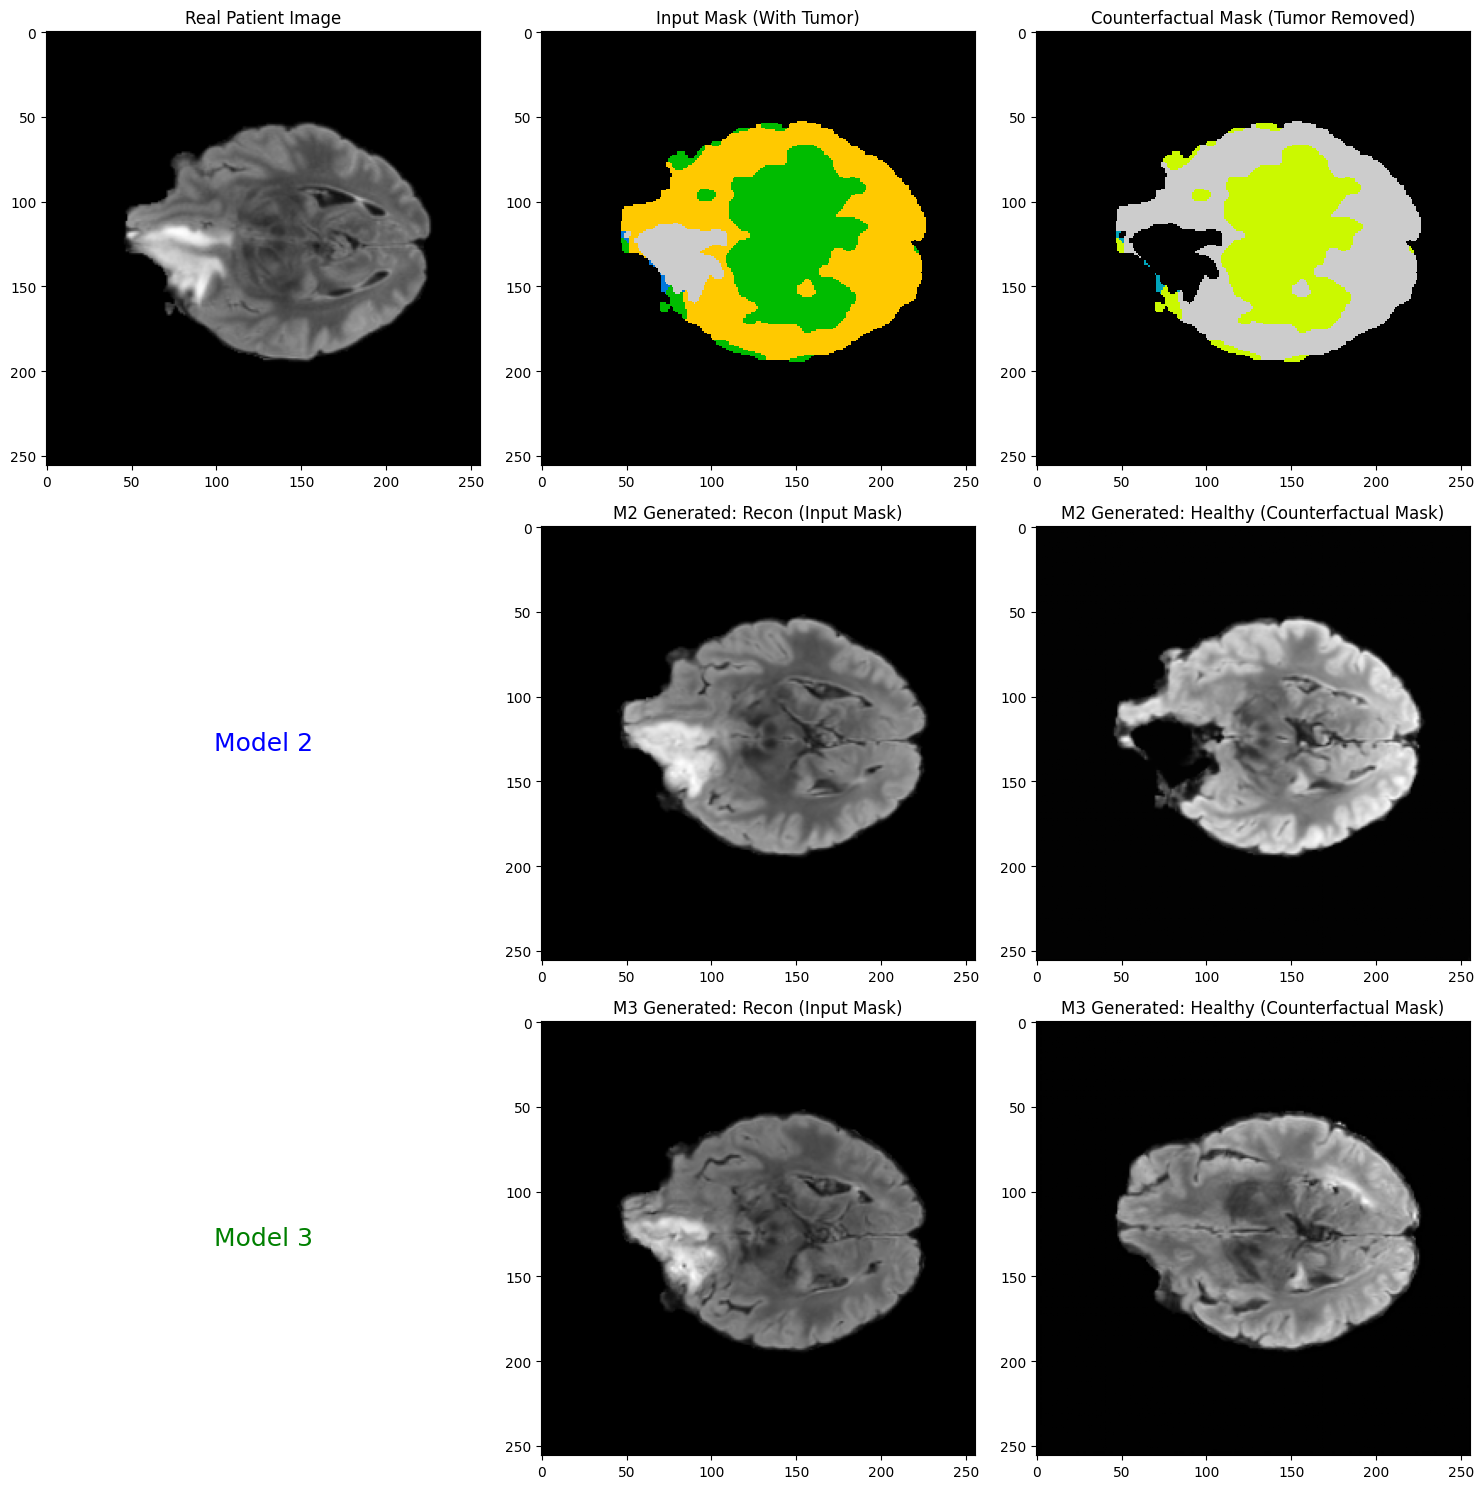

In [9]:
import torch
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from tqdm.auto import tqdm
from PIL import Image

def display_tensor_as_img(img_tensor):
    return img_tensor[0, 0].cpu().numpy().clip(0, 1)


# Set to None to use the existing random selection logic (finds a random tumor slice).
# user_defined_sample_idx = None
user_defined_sample_idx = 51 #or try out anything between 84 or 49 or 51

# Pick a RANDOM Validation Sample (With Tumor)
ds = BratsFlairSliceDataset(DATA_ROOT, split="test")

if user_defined_sample_idx is not None:
    sample_idx = user_defined_sample_idx
    print(f"Using user-defined sample index: {sample_idx}")
    if not (0 <= sample_idx < len(ds)):
        print(f"Warning: User-defined index {sample_idx} is out of bounds for dataset of size {len(ds)}. Reverting to random selection.")
        user_defined_sample_idx = None

if user_defined_sample_idx is None:
    print("Scanning validation set for tumor slices (this may take a moment)...")
    tumor_indices = []
    # Reduced scan_limit to speed up execution
    scan_limit = min(len(ds), 100)

    # Collect indices of tumor slices
    for i in range(scan_limit):
        _, mask_path_temp = ds.items[i]
        if (load_diffusion_mask(mask_path_temp) > (3.5 / 255.0)).any():
            tumor_indices.append(i)

    if not tumor_indices:
        print("No tumor slices found! Using a fixed slice (index 85) instead.")
        sample_idx = 85
    else:
        sample_idx = random.choice(tumor_indices)
        print(f"Found {len(tumor_indices)} tumor slices. Selected Index: {sample_idx}")


print(f"Generating for Validation Sample {sample_idx}...")
img_path, mask_path = ds.items[sample_idx]

real_img_for_display = load_image(img_path).unsqueeze(0).to(device)

real_mask_diffusion = load_diffusion_mask(mask_path).to(device)

gt_mask_rgb = np.array(Image.open(mask_path).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
gt_mask_labels = rgb_to_label(gt_mask_rgb)

healthy_mask_diffusion = real_mask_diffusion.clone()
tumor_thresh = (4.0 / 255.0) - 1e-4
healthy_mask_diffusion[healthy_mask_diffusion > tumor_thresh] = 0

print("\nGenerating 'Healthy' version (Counterfactual) using Model 2...")
gen_healthy_m2 = sample_seg_guided(
    unet=unet_m2,
    train_scheduler=sched_m2,
    real_mask=healthy_mask_diffusion,
    init_image=real_img_for_display,
    num_steps=50,
    seed=42 + sample_idx,
    mode="healthy",
    strength=0.70,
)

print("Generating 'Reconstruct' version (with original mask) using Model 2...")
gen_recon_m2 = sample_seg_guided(
    unet=unet_m2,
    train_scheduler=sched_m2,
    real_mask=real_mask_diffusion,
    init_image=real_img_for_display,
    num_steps=50,
    seed=42 + sample_idx,
    mode="reconstruct",
    strength=0.20,
)

print("Generating 'Healthy' version (Counterfactual) using Model 3...")
gen_healthy_m3 = sample_seg_guided(
    unet=unet_m3,
    train_scheduler=sched_m3,
    real_mask=healthy_mask_diffusion,
    init_image=real_img_for_display,
    num_steps=50,
    seed=42 + sample_idx,
    mode="healthy",
    strength=0.70,
)

print("Generating 'Reconstruct' version (with original mask) using Model 3...")
gen_recon_m3 = sample_seg_guided(
    unet=unet_m3,
    train_scheduler=sched_m3,
    real_mask=real_mask_diffusion,
    init_image=real_img_for_display,
    num_steps=50,
    seed=42 + sample_idx,
    mode="reconstruct",
    strength=0.20,
)


fig, axes = plt.subplots(3, 3, figsize=(15, 15))

axes[0,0].imshow(display_tensor_as_img(real_img_for_display), cmap='gray')
axes[0,0].set_title("Real Patient Image")
axes[0,1].imshow(gt_mask_labels, cmap='nipy_spectral', interpolation='nearest')
axes[0,1].set_title("Input Mask (With Tumor)")

healthy_mask_labels_for_display = (healthy_mask_diffusion[0,0].cpu().numpy() * 255.0).astype(np.int64)

axes[0,2].imshow(healthy_mask_labels_for_display, cmap='nipy_spectral', interpolation='nearest')
axes[0,2].set_title("Counterfactual Mask (Tumor Removed)")

axes[1,0].axis('off')
axes[1,0].text(0.5, 0.5, 'Model 2', horizontalalignment='center', verticalalignment='center',
               fontsize=18, color='blue', transform=axes[1,0].transAxes)

axes[1,1].imshow(display_tensor_as_img(gen_recon_m2), cmap='gray')
axes[1,1].set_title("M2 Generated: Recon (Input Mask)")

axes[1,2].imshow(display_tensor_as_img(gen_healthy_m2), cmap='gray')
axes[1,2].set_title("M2 Generated: Healthy (Counterfactual Mask)")

axes[2,0].axis('off')
axes[2,0].text(0.5, 0.5, 'Model 3', horizontalalignment='center', verticalalignment='center',
               fontsize=18, color='green', transform=axes[2,0].transAxes)

axes[2,1].imshow(display_tensor_as_img(gen_recon_m3), cmap='gray')
axes[2,1].set_title("M3 Generated: Recon (Input Mask)")

axes[2,2].imshow(display_tensor_as_img(gen_healthy_m3), cmap='gray')
axes[2,2].set_title("M3 Generated: Healthy (Counterfactual Mask)")

plt.tight_layout()
plt.show()